In [2]:
import matplotlib.pyplot as plt
import numpy as np
import utils
import network_layers
import tensorflow as tf
from keras import layers, Model

In [3]:
#set the necessary seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import datasets

### Breast cancer dataset

In [4]:
train_pairs_breast, val_pairs_breast, test_pairs_breast = utils.split_dataset(utils.create_list())
print(f"Number of training pairs: {len(train_pairs_breast)}")
print(f"Number of val pairs: {len(val_pairs_breast)}")
print(f"Number of test_pairs pairs: {len(test_pairs_breast)}")

Number of training pairs: 388
Number of val pairs: 129
Number of test_pairs pairs: 130


In [6]:
train_dataset_breast = utils.create_dataset(train_pairs_breast, augment=True)
val_dataset_breast = utils.create_dataset(val_pairs_breast)
test_dataset_breast = utils.create_dataset(test_pairs_breast)

In [7]:
batch_size = 8

In [8]:
#batch the dataset and shuffle the training set

train_dataset_breast = train_dataset_breast.shuffle(buffer_size=len(train_pairs_breast)).batch(batch_size)
val_dataset_breast = val_dataset_breast.batch(batch_size)
test_dataset_breast = test_dataset_breast.batch(batch_size)

### Skin cancer dataset

In [10]:
train_dataset_skin = utils.create_dataset(utils.create_list_skin("Datasets/ISIC-2017_Training_Data", "Datasets/ISIC-2017_Training_Part1_GroundTruth"), augment=True)
val_dataset_skin = utils.create_dataset(utils.create_list_skin("Datasets/ISIC-2017_Validation_Data", "Datasets/ISIC-2017_Validation_Part1_GroundTruth"))
test_dataset_skin =utils. create_dataset(utils.create_list_skin("Datasets/ISIC-2017_Test_v2_Data", "Datasets/ISIC-2017_Test_v2_Part1_GroundTruth"))

In [11]:
train_dataset_skin = train_dataset_skin.shuffle(buffer_size=2000).batch(batch_size)
val_dataset_skin = val_dataset_skin.batch(batch_size)
test_dataset_skin = test_dataset_skin.batch(batch_size)

### Brain cancer datatset

In [4]:
train_pairs_brain, val_pairs_brain, test_pairs_brain = utils.split_dataset(utils.create_list_brain())
print(f"Number of training pairs: {len(train_pairs_brain)}")
print(f"Number of val pairs: {len(val_pairs_brain)}")
print(f"Number of test_pairs pairs: {len(test_pairs_brain)}")

Number of training pairs: 1838
Number of val pairs: 613
Number of test_pairs pairs: 613


In [5]:
train_dataset_brain = utils.create_dataset(train_pairs_brain, augment=True)
val_dataset_brain = utils.create_dataset(val_pairs_brain)
test_dataset_brain = utils.create_dataset(test_pairs_brain)

In [8]:
train_dataset_brain = train_dataset_brain.shuffle(buffer_size=len(train_pairs_brain)).batch(batch_size)
val_dataset_brain = val_dataset_brain.batch(batch_size)
test_dataset_brain = test_dataset_brain.batch(batch_size)

## Architecture definition

In [9]:
def basic_unet(input_size, num_filters=16):
    inputs = tf.keras.Input(shape=input_size)

    #encoder
    first_conv = network_layers.convolutional_layer(inputs, num_filters)
    first_layer = layers.MaxPool2D(pool_size=(2, 2))(first_conv)

    second_conv = network_layers.convolutional_layer(first_layer, num_filters * 2)
    second_layer = layers.MaxPool2D(pool_size=(2, 2))(second_conv)

    third_conv = network_layers.convolutional_layer(second_layer, num_filters * 4)
    third_layer = layers.MaxPool2D(pool_size=(2, 2))(third_conv)

    fourth_conv = network_layers.convolutional_layer(third_layer, num_filters * 8)
    fourth_layer = layers.MaxPool2D(pool_size=(2, 2))(fourth_conv)

    fifth_conv = network_layers.convolutional_layer(fourth_layer, num_filters * 16)

    #decoder
    first_deconv = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(fifth_conv)
    sixth_layer = layers.concatenate([first_deconv, fourth_conv])
    sixth_conv = network_layers.convolutional_layer(sixth_layer, num_filters * 8, dropout=True)

    second_deconv = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(sixth_conv)
    seventh_layer = layers.concatenate([second_deconv, third_conv])
    seventh_conv = network_layers.convolutional_layer(seventh_layer, num_filters * 4, dropout=True)

    third_deconv = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(seventh_conv)
    eighth_layer = layers.concatenate([third_deconv, second_conv])
    eighth_conv = network_layers.convolutional_layer(eighth_layer, num_filters * 2, dropout=True)

    fourth_deconv = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(eighth_conv)
    ninth_layer = layers.concatenate([fourth_deconv, first_conv])
    ninth_conv = network_layers.convolutional_layer(ninth_layer, num_filters, dropout=True)

    #output Layer
    output = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(ninth_conv)

    unet = Model(inputs=inputs, outputs=output)

    return unet

In [11]:
basic_unet_model = basic_unet(input_size=(256, 256, 3))

In [49]:
basic_unet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 256, 256, 16)         448       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_72 (Ba  (None, 256, 256, 16)         64        ['conv2d_76[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_72 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_72

### Fit on the breast cancer dataset

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
training_times = []

num_experiments = 5
input_size = (256, 256, 3)

best_dice = 0.0

for i in range(num_experiments):
    print(f"Training experiment {i+1}/{num_experiments}")

    basic_unet_model = basic_unet(input_size)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    basic_unet_model.compile(optimizer=optimizer,
                       loss=utils.tversky_loss,
                       metrics=[utils.dice_coefficient, utils.iou, "accuracy", tf.keras.metrics.Precision(name="precision_metric"), tf.keras.metrics.Recall(name="recall_metric")])

    callbacks = [
        EarlyStopping(monitor='val_dice_coefficient', patience=13, restore_best_weights=True, mode='max', verbose=0),
        ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=7, min_lr=1e-6, mode='max', verbose=0)
    ]

    start_time = time.time()

    history = basic_unet_model.fit(train_dataset_breast, validation_data=val_dataset_breast, epochs=200, callbacks=callbacks, verbose=0)

    elapsed_time = time.time() - start_time
    training_times.append(elapsed_time)
    print(f"Training Time for Experiment {i+1}: {elapsed_time:.2f} seconds")

    #select best epoch in terms of dice
    best_epoch_index = np.argmax(history.history['val_dice_coefficient'])

    #get the metrics for that epoch
    final_dice = history.history['val_dice_coefficient'][best_epoch_index]
    final_iou = history.history['val_iou'][best_epoch_index]
    final_precision = history.history['val_precision_metric'][best_epoch_index]
    final_recall = history.history['val_recall_metric'][best_epoch_index]
    final_accuracy = history.history['val_accuracy'][best_epoch_index]

    #store the results
    dice_scores.append(final_dice)
    iou_scores.append(final_iou)
    precision_scores.append(final_precision)
    recall_scores.append(final_recall)
    accuracy_scores.append(final_accuracy)

    print(f"Dice Coefficient: {final_dice}", f"IoU: {final_iou}", f"Precision: {final_precision}", f"Recall: {final_recall}", f"Accuracy: {final_accuracy}")

    #save best model based on Dice score
    if final_dice > best_dice:
        best_dice = final_dice
        best_model = basic_unet_model
        basic_unet_model.save("best_basic_unet_breast.h5")
        print(f"New best model saved")

#compute mean ± std
dice_mean, dice_std = np.mean(dice_scores), np.std(dice_scores)
iou_mean, iou_std = np.mean(iou_scores), np.std(iou_scores)
precision_mean, precision_std = np.mean(precision_scores), np.std(precision_scores)
recall_mean, recall_std = np.mean(recall_scores), np.std(recall_scores)
accuracy_mean, accuracy_std = np.mean(accuracy_scores), np.std(accuracy_scores)
time_mean, time_std = np.mean(training_times), np.std(training_times)

print("Final Results (Across All Runs):")
print(f"Dice Score: {dice_mean:.2f} ± {dice_std:.2f}")
print(f"IoU Score: {iou_mean:.2f} ± {iou_std:.2f}")
print(f"Precision Score: {precision_mean:.2f} ± {precision_std:.2f}")
print(f"Recall Score: {recall_mean:.2f} ± {recall_std:.2f}")
print(f"Accuracy Score: {accuracy_mean:.2f} ± {accuracy_std:.2f}")
print(f"Training Time: {time_mean:.2f} ± {time_std:.2f} seconds")
print(f"Best Model Dice Score: {best_dice:.4f} (Saved as 'best_basic_unet_breast.h5')")

Training experiment 1/5


I0000 00:00:1739206088.044717   13172 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Time for Experiment 1: 531.84 seconds
Dice Coefficient: 0.6548338532447815 IoU: 0.4918386936187744 Precision: 0.7747526168823242 Recall: 0.5674335956573486 Accuracy: 0.9474079012870789


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved
Training experiment 2/5
Training Time for Experiment 2: 469.85 seconds
Dice Coefficient: 0.6520519256591797 IoU: 0.4910610318183899 Precision: 0.6611234545707703 Recall: 0.6550527215003967 Accuracy: 0.9398903250694275
Training experiment 3/5
Training Time for Experiment 3: 479.73 seconds
Dice Coefficient: 0.620977520942688 IoU: 0.46521350741386414 Precision: 0.8030006885528564 Recall: 0.49386581778526306 Accuracy: 0.9448577165603638
Training experiment 4/5
Training Time for Experiment 4: 662.29 seconds
Dice Coefficient: 0.6791243553161621 IoU: 0.5214102864265442 Precision: 0.6788145303726196 Recall: 0.6943897008895874 Accuracy: 0.9438549876213074
New best model saved
Training experiment 5/5
Training Time for Experiment 5: 574.69 seconds
Dice Coefficient: 0.6185857057571411 IoU: 0.46567094326019287 Precision: 0.7382568120956421 Recall: 0.6009658575057983 Accuracy: 0.9461842775344849
Final Results (Across All Runs):
Dice Score: 0.65 ± 0.02
IoU Score: 0.49 ± 0.02
Prec

### Fit on the skin cancer dataset

In [13]:
dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
training_times = []

num_experiments = 5
input_size = (256, 256, 3)

best_dice = 0.0

for i in range(num_experiments):
    print(f"Training experiment {i+1}/{num_experiments}")

    basic_unet_model = basic_unet(input_size)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    basic_unet_model.compile(optimizer=optimizer,
                       loss=utils.tversky_loss,
                       metrics=[utils.dice_coefficient, utils.iou, "accuracy", tf.keras.metrics.Precision(name="precision_metric"), tf.keras.metrics.Recall(name="recall_metric")])

    callbacks = [
        EarlyStopping(monitor='val_dice_coefficient', patience=13, restore_best_weights=True, mode='max', verbose=0),
        ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=7, min_lr=1e-6, mode='max', verbose=0)
    ]

    start_time = time.time()

    history = basic_unet_model.fit(train_dataset_skin, validation_data=val_dataset_skin, epochs=100, callbacks=callbacks, verbose=0)

    elapsed_time = time.time() - start_time
    training_times.append(elapsed_time)
    print(f"Training Time for Experiment {i+1}: {elapsed_time:.2f} seconds")

    #select best epoch in terms of dice
    best_epoch_index = np.argmax(history.history['val_dice_coefficient'])

    #get the metrics for that epoch
    final_dice = history.history['val_dice_coefficient'][best_epoch_index]
    final_iou = history.history['val_iou'][best_epoch_index]
    final_precision = history.history['val_precision_metric'][best_epoch_index]
    final_recall = history.history['val_recall_metric'][best_epoch_index]
    final_accuracy = history.history['val_accuracy'][best_epoch_index]

    #store the results
    dice_scores.append(final_dice)
    iou_scores.append(final_iou)
    precision_scores.append(final_precision)
    recall_scores.append(final_recall)
    accuracy_scores.append(final_accuracy)

    print(f"Dice Coefficient: {final_dice}", f"IoU: {final_iou}", f"Precision: {final_precision}", f"Recall: {final_recall}", f"Accuracy: {final_accuracy}")

    #save best model based on Dice score
    if final_dice > best_dice:
        best_dice = final_dice
        best_model = basic_unet_model
        basic_unet_model.save("best_basic_unet_skin.h5")
        print(f"New best model saved")

#compute mean ± std
dice_mean, dice_std = np.mean(dice_scores), np.std(dice_scores)
iou_mean, iou_std = np.mean(iou_scores), np.std(iou_scores)
precision_mean, precision_std = np.mean(precision_scores), np.std(precision_scores)
recall_mean, recall_std = np.mean(recall_scores), np.std(recall_scores)
accuracy_mean, accuracy_std = np.mean(accuracy_scores), np.std(accuracy_scores)
time_mean, time_std = np.mean(training_times), np.std(training_times)

print("Final Results (Across All Runs):")
print(f"Dice Score: {dice_mean:.2f} ± {dice_std:.2f}")
print(f"IoU Score: {iou_mean:.2f} ± {iou_std:.2f}")
print(f"Precision Score: {precision_mean:.2f} ± {precision_std:.2f}")
print(f"Recall Score: {recall_mean:.2f} ± {recall_std:.2f}")
print(f"Accuracy Score: {accuracy_mean:.2f} ± {accuracy_std:.2f}")
print(f"Training Time: {time_mean:.2f} ± {time_std:.2f} seconds")
print(f"Best Model Dice Score: {best_dice:.4f} (Saved as 'best_basic_unet_skin.h5')")

Training experiment 1/5


I0000 00:00:1739216157.929650   67716 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Time for Experiment 1: 4177.42 seconds
Dice Coefficient: 0.8062329292297363 IoU: 0.6888327598571777 Precision: 0.8457568883895874 Recall: 0.7645635604858398 Accuracy: 0.9347679615020752


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved
Training experiment 2/5
Training Time for Experiment 2: 3047.23 seconds
Dice Coefficient: 0.8003872036933899 IoU: 0.6808502674102783 Precision: 0.8690135478973389 Recall: 0.7317819595336914 Accuracy: 0.9341546893119812
Training experiment 3/5
Training Time for Experiment 3: 3398.36 seconds
Dice Coefficient: 0.8085063099861145 IoU: 0.6897390484809875 Precision: 0.8151325583457947 Recall: 0.7911481857299805 Accuracy: 0.9324297308921814
New best model saved
Training experiment 4/5
Training Time for Experiment 4: 2110.97 seconds
Dice Coefficient: 0.8031582236289978 IoU: 0.683013379573822 Precision: 0.871999979019165 Recall: 0.7349418997764587 Accuracy: 0.9351145625114441
Training experiment 5/5
Training Time for Experiment 5: 3089.87 seconds
Dice Coefficient: 0.8199000358581543 IoU: 0.7030164003372192 Precision: 0.8204318881034851 Recall: 0.8265302181243896 Accuracy: 0.9383232593536377
New best model saved
Final Results (Across All Runs):
Dice Score: 0.81 ± 0.01
IoU Sc

### Fit on the brain cancer dataset

In [11]:
dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
training_times = []

num_experiments = 5
input_size = (256, 256, 3)

best_dice = 0.0

for i in range(num_experiments):
    print(f"Training experiment {i+1}/{num_experiments}")

    basic_unet_model = basic_unet(input_size)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    basic_unet_model.compile(optimizer=optimizer,
                       loss=utils.tversky_loss,
                       metrics=[utils.dice_coefficient, utils.iou, "accuracy", tf.keras.metrics.Precision(name="precision_metric"), tf.keras.metrics.Recall(name="recall_metric")])

    callbacks = [
        EarlyStopping(monitor='val_dice_coefficient', patience=13, restore_best_weights=True, mode='max', verbose=0),
        ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=7, min_lr=1e-6, mode='max', verbose=0)
    ]

    start_time = time.time()

    history = basic_unet_model.fit(train_dataset_brain, validation_data=val_dataset_brain, epochs=200, callbacks=callbacks, verbose=0)

    elapsed_time = time.time() - start_time
    training_times.append(elapsed_time)
    print(f"Training Time for Experiment {i+1}: {elapsed_time:.2f} seconds")

    #select best epoch in terms of dice
    best_epoch_index = np.argmax(history.history['val_dice_coefficient'])

    #get the metrics for that epoch
    final_dice = history.history['val_dice_coefficient'][best_epoch_index]
    final_iou = history.history['val_iou'][best_epoch_index]
    final_precision = history.history['val_precision_metric'][best_epoch_index]
    final_recall = history.history['val_recall_metric'][best_epoch_index]
    final_accuracy = history.history['val_accuracy'][best_epoch_index]

    #store the results
    dice_scores.append(final_dice)
    iou_scores.append(final_iou)
    precision_scores.append(final_precision)
    recall_scores.append(final_recall)
    accuracy_scores.append(final_accuracy)

    print(f"Dice Coefficient: {final_dice}", f"IoU: {final_iou}", f"Precision: {final_precision}", f"Recall: {final_recall}", f"Accuracy: {final_accuracy}")

    #save best model based on Dice score
    if final_dice > best_dice:
        best_dice = final_dice
        best_model = basic_unet_model
        basic_unet_model.save("best_basic_unet_brain.h5")
        print(f"New best model saved")

#compute mean ± std
dice_mean, dice_std = np.mean(dice_scores), np.std(dice_scores)
iou_mean, iou_std = np.mean(iou_scores), np.std(iou_scores)
precision_mean, precision_std = np.mean(precision_scores), np.std(precision_scores)
recall_mean, recall_std = np.mean(recall_scores), np.std(recall_scores)
accuracy_mean, accuracy_std = np.mean(accuracy_scores), np.std(accuracy_scores)
time_mean, time_std = np.mean(training_times), np.std(training_times)

print("Final Results (Across All Runs):")
print(f"Dice Score: {dice_mean:.2f} ± {dice_std:.2f}")
print(f"IoU Score: {iou_mean:.2f} ± {iou_std:.2f}")
print(f"Precision Score: {precision_mean:.2f} ± {precision_std:.2f}")
print(f"Recall Score: {recall_mean:.2f} ± {recall_std:.2f}")
print(f"Accuracy Score: {accuracy_mean:.2f} ± {accuracy_std:.2f}")
print(f"Training Time: {time_mean:.2f} ± {time_std:.2f} seconds")
print(f"Best Model Dice Score: {best_dice:.4f} (Saved as 'best_basic_unet_skin.h5')")

Training experiment 1/5


I0000 00:00:1739268826.474436   97553 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Time for Experiment 1: 2871.05 seconds
Dice Coefficient: 0.7269467711448669 IoU: 0.5829787254333496 Precision: 0.7903299331665039 Recall: 0.6928909420967102 Accuracy: 0.991180956363678


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved
Training experiment 2/5
Training Time for Experiment 2: 3372.29 seconds
Dice Coefficient: 0.7324671745300293 IoU: 0.5881706476211548 Precision: 0.8160882592201233 Recall: 0.6831697225570679 Accuracy: 0.9915364980697632
New best model saved
Training experiment 3/5
Training Time for Experiment 3: 2615.89 seconds
Dice Coefficient: 0.7202432155609131 IoU: 0.5721774101257324 Precision: 0.7991493344306946 Recall: 0.67440265417099 Accuracy: 0.991107702255249
Training experiment 4/5
Training Time for Experiment 4: 2145.10 seconds
Dice Coefficient: 0.7274065613746643 IoU: 0.5814776420593262 Precision: 0.7575132846832275 Recall: 0.7201462984085083 Accuracy: 0.9907771348953247
Training experiment 5/5
Training Time for Experiment 5: 1578.53 seconds
Dice Coefficient: 0.7297810912132263 IoU: 0.5844861268997192 Precision: 0.7310348153114319 Recall: 0.7534513473510742 Accuracy: 0.9905228018760681
Final Results (Across All Runs):
Dice Score: 0.73 ± 0.00
IoU Score: 0.58 ± 0.01
Preci

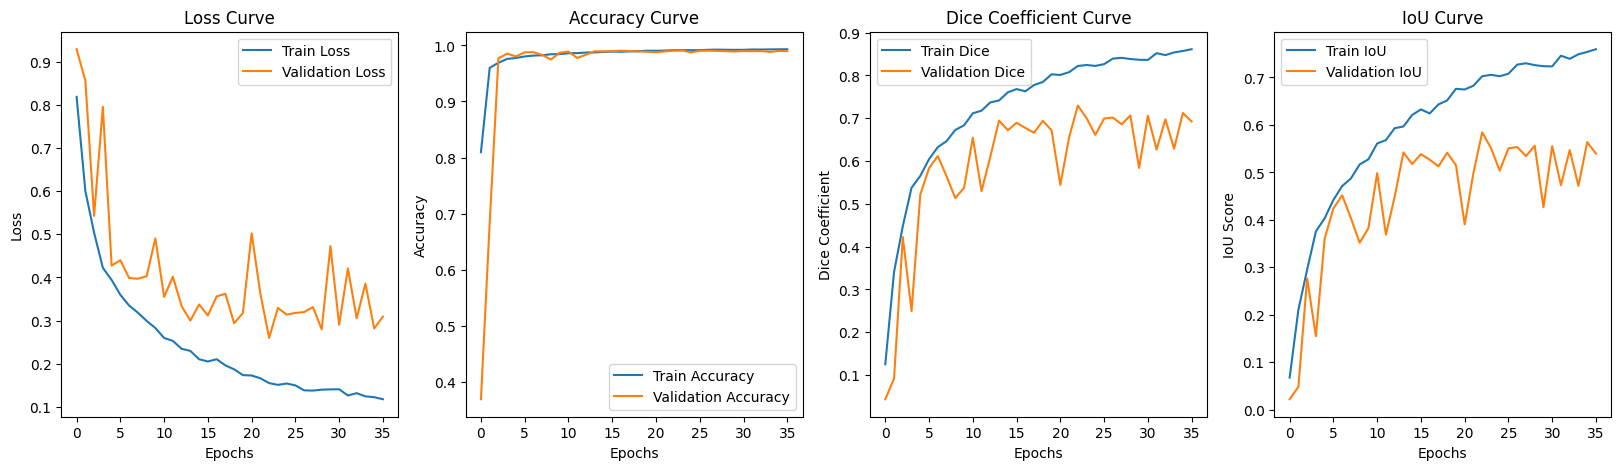

In [15]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Curve')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history.history['iou'], label='Train IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.title('IoU Curve')
plt.legend()

plt.show()